In [1]:
# Checking out what EOS signal would look like 
import matplotlib.pyplot as plt;
import numpy as np;
from scipy.constants import c;
from scipy.interpolate import interp1d;
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter;
import sys; 
#sys.path.insert(0, "..\\..\\python\\"); # Windows
sys.path.insert(0, "../../python"); # Ubuntu
sys.path.insert(0, "../current_profiles");
from crystal import crystal
import current_profiles as cp;
from ebeam import ebeam;
from laser import laser;
from plotting import makefig;
import phase_retard as pr;
import thz;

In [2]:
# Bunch parameters:
sigz    = 5.2e-6;
sigt    = sigz / c;
dt      = sigt / 10;
N       = 8000;
t       = np.linspace(-N * dt / 2, N * dt / 2, N);
Q_drive = 1.5e-9;
Q_wit   = 0.5e-9;
z_off   = 150e-6;
r0      = 5e-3;
drive   = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0});
wit     = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : z_off});
Er      = drive.Er + wit.Er;
# Initialize crystals and their parameters
cry = crystal('gap');
d    = 100e-6; # m
nslice = 100;
j     = np.arange(1, nslice, 1);
dz    = d / nslice;
d_arr = (j - 0.5) * dz;
# Initialize probe
y0 = 800e-9; 
dy = 27e-9;
tp = 30e-15;
probe = laser({'y0' : y0, 'dy' : dy, 'tp' : tp});

In [3]:
FEr, f = thz.raw_field(Er, drive.t)
Ec, tt  = thz.cry_field(drive.t, FEr, f, d, probe, cry, nslice = nslice)

In [5]:
# Laser propagates backward 
#Ec_loop = np.flip(Ec, axis = 1)
tau = np.linspace(0, 3000, 1000) * 1e-15;
n0 = cry.indref(np.array([probe.y0]))[0]
dz = abs(d_arr[1] - d_arr[0])
amp = 2 * np.pi * n0**3 * dz / (probe.y0);
Lchar, vg_opt = probe.laser_l_char(cry);
gamma = np.zeros(len(tau));
t_probe = probe.t_shift * 1e-12; # s
t_delay = tau #+ t_probe;
vg_eff = vg_opt * np.cos(15 * np.pi / 180);
te = tt*1e-12
for j in range(len(d_arr)-1, 0, -1):
    f    = interp1d(te, np.real(Ec[:, j]),\
                    bounds_error = False, fill_value = 0);
    d_laser = d - d_arr[j];
    t_interp = (d_laser / vg_eff) + t_delay;
    E_eff = f(t_interp);
    gamma += amp * E_eff;

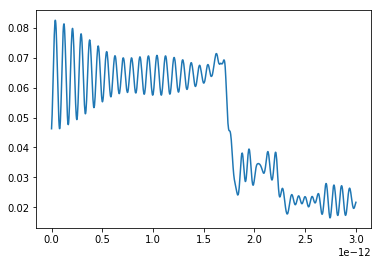

In [8]:
plt.plot(tau, gamma);
plt.show();

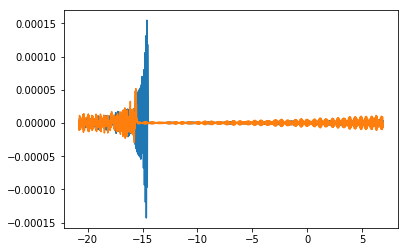

In [12]:
plt.plot(tt, np.flip(np.real(Ec[:, 0]), axis = 0))
plt.plot(tt, np.flip(np.real(Ec[:, -1]), axis = 0), '-')
#plt.xlim([0, 5])
plt.show()